In [95]:
import pandas as pd
import urllib.parse
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from ipyleaflet import Map, Heatmap

In [96]:

df_main = pd.read_csv("properties_data.csv", low_memory=False)
df = df_main[["id","location","Zip","Type","Subtype",
    "Price","Transaction Type","Bedrooms","Living area","Kitchen type",
    "Furnished","How many fireplaces?","Terrace","Terrace surface",
    "Garden","Garden surface","Surface of the plot","Number of frontages",
    "Swimming pool","Building condition","Primary energy consumption"]]
df = df.set_index("id")
df = df.drop(df[df["Type"]=="house group"].index)
df = df.drop(df[df["Type"]=="apartment group"].index)
df = df.rename(columns={
    'location' :'Locality',
    'Transaction Type' : 'Type of sale',
    'Type' :'Type of property',
    'Subtype' : 'Subtype of property',
    'Number of frontages': 'Number of facades',
    'Bedrooms':'Number of rooms',
    'Surface of the plot' :'Surface of the land',
    'Kitchen type' : 'Fully equipped kitchen',
    'How many fireplaces?' : 'Open fire'
})
 
#put the columns in a specific order'
df = df.reindex(columns=['Locality',"Zip", 'Type of property', 'Subtype of property',
                         'Type of sale', 'Price',
                         'Building condition','Building Cond. values',
                         'Number of facades', 'Number of rooms', 
                         'Living area',
                         'Furnished','Fully equipped kitchen','Kitchen values',
                         'Surface of the land',
                         'Primary energy consumption','Energy_classes' ,
                         'Terrace', 'Terrace surface','Garden','Garden surface',
                         'Open fire', 'Swimming pool'])

df_houses = df[df['Type of property'] == 'house']
df_apartments = df[df['Type of property'] == 'apartment']

all_missing_value_df = df.isnull().mean() * 100
houses_missing_value_df = df_houses.isnull().mean() * 100
apartments_missing_value_df = df_apartments.isnull().mean() * 100
pd.set_option('display.float_format', '{:.2f}'.format)
print("all_missing_value")
print(all_missing_value_df)
print("")
print("houses_missing_value")
print(houses_missing_value_df)
print("")
print("apartments_missing")
print(apartments_missing_value_df)

def clean_and_convert(column):
    column = column.apply(lambda x: re.sub('\D+', '', str(x)))
    column = column.replace('', np.nan)
    return column

df['Living area'] = clean_and_convert(df['Living area'])
df['Terrace surface'] = clean_and_convert(df['Terrace surface'])
df['Garden surface'] = clean_and_convert(df['Garden surface'])
df['Surface of the land'] = clean_and_convert(df['Surface of the land'])
df['Primary energy consumption'] = clean_and_convert(df['Primary energy consumption'])
df['Locality'] = df['Locality'].apply(urllib.parse.unquote)

# missing_value_df = df.isnull().mean() * 100
# missing_value_df

conditions = [
    (df['Garden']== "Yes"),
    (df["Garden"].isna()) & (df["Garden surface"].isna()),
    (df["Garden surface"].notna())
    ]
values = [1, 0, 1]
df['Garden'] = np.select(conditions, values)

df.loc[(df["Garden"] == 0 ) & (df["Garden surface"].isna()), 'Garden surface'] = 0
conditions = [
    (df['Terrace']== "Yes"),
    (df["Terrace"].isna()) & (df["Terrace surface"].isna()),
    (df["Terrace surface"].notna())
    ]
values = [1, 0, 1]
df['Terrace'] = np.select(conditions, values)

df.loc[(df["Terrace"] == 0 ) & (df["Terrace surface"].isna()), 'Terrace surface'] = 0
def nan_replacement(column):
    column = column.replace("Yes",1)
    column = column.replace("No",0)
    column = column.replace('', np.nan).fillna(0)
    return column

df['Furnished'] = nan_replacement(df['Furnished'])
df['Swimming pool'] = nan_replacement(df['Swimming pool'])
df['Open fire'] = nan_replacement(df['Open fire'])
df["Price"] = df["Price"].astype(int)
df = df.astype({"Price":"int",
                "Number of rooms":"float",
                "Living area":"float",
                "Terrace surface":"float",
                "Garden surface":"float",
                "Surface of the land":"float",
                "Number of facades":"float",
                "Primary energy consumption":"float"})
# Mapping dictionary for replacing values in the "kitchen" column
kitchen_mapping = {
    np.nan: -1,
    'Not installed': 0,
    'Installed': 1,
    'Semi equipped': 2,
    'Hyper equipped': 3,
    'USA uninstalled' :0,
    'USA installed': 1,
    'USA semi equipped': 2,
    'USA hyper equipped' :3
}
# Replace values in the "Kitchen type" column with corresponding numbers and create a new column called "Kitchen values"
df['Kitchen values'] = df['Fully equipped kitchen'].map(kitchen_mapping).fillna(df['Fully equipped kitchen']).astype(int)
building_cond_mapping = {
    np.nan: -1,
    'To restore': 0,
    'To be done up': 2,
    'Just renovated': 3,
    'To renovate': 1,
    'Good': 3,
    'As new' :4
}

df['Building Cond. values'] = df['Building condition'].map(building_cond_mapping).fillna(df['Building condition']).astype(int)
df = df.drop(df[df["Living area"].isna()].index)
#Missing values fillied with 1
df["Primary energy consumption"] = np.where((df["Primary energy consumption"] != int) & (df["Primary energy consumption"] == ""), 0, df["Primary energy consumption"])
df["Primary energy consumption"] = df["Primary energy consumption"].replace("",np.nan).fillna(-1).astype(int)

#New column with energy classes 
conditions = [
    (df['Primary energy consumption']==-1),
    (df['Primary energy consumption']>=1)&(df['Primary energy consumption']<100),
    (df['Primary energy consumption']>=100)&(df['Primary energy consumption']<200),
    (df['Primary energy consumption']>=200)&(df['Primary energy consumption']<300),
    (df['Primary energy consumption']>=300)&(df['Primary energy consumption']<400),
    (df['Primary energy consumption']>=400)&(df['Primary energy consumption']<500),
    (df['Primary energy consumption']>=500)&(df['Primary energy consumption']<600),
    (df['Primary energy consumption']>=600)
]

values = [-1,7, 6, 5, 4, 3, 2, 1]

df['Energy_classes'] = np.select(conditions, values)
print(f"The DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.")
# print(missing_value_df)
df.to_csv("clean_data.csv")

all_missing_value
Locality                       0.00
Zip                            0.00
Type of property               0.00
Subtype of property            0.00
Type of sale                   0.00
Price                          0.00
Building condition            15.89
Building Cond. values        100.00
Number of facades             23.73
Number of rooms                1.86
Living area                    3.40
Furnished                     46.42
Fully equipped kitchen        22.08
Kitchen values               100.00
Surface of the land           50.22
Primary energy consumption     0.00
Energy_classes               100.00
Terrace                       75.88
Terrace surface               53.57
Garden                        87.76
Garden surface                74.73
Open fire                     94.57
Swimming pool                 56.39
dtype: float64

houses_missing_value
Locality                       0.00
Zip                            0.00
Type of property               0.00
Subtype o

In [97]:
df_houses = df[df['Type of property'] == 'house']
df_apartments = df[df['Type of property'] == 'apartment']

all_missing_value_df = df.isnull().mean() * 100
houses_missing_value_df = df_houses.isnull().mean() * 100
apartments_missing_value_df = df_apartments.isnull().mean() * 100

print("all_missing_value")
print(all_missing_value_df)
print("")
print("houses_missing_value")
print(houses_missing_value_df)
print("")
print("apartments_missing")
print(apartments_missing_value_df)

all_missing_value
Locality                      0.00
Zip                           0.00
Type of property              0.00
Subtype of property           0.00
Type of sale                  0.00
Price                         0.00
Building condition           15.77
Building Cond. values         0.00
Number of facades            23.31
Number of rooms               1.84
Living area                   0.00
Furnished                     0.00
Fully equipped kitchen       21.81
Kitchen values                0.00
Surface of the land          49.83
Primary energy consumption    0.00
Energy_classes                0.00
Terrace                       0.00
Terrace surface              23.89
Garden                        0.00
Garden surface               12.25
Open fire                     0.00
Swimming pool                 0.00
dtype: float64

houses_missing_value
Locality                      0.00
Zip                           0.00
Type of property              0.00
Subtype of property           0.00


In [98]:
df['Price of square meter'] = df['Price'] / df['Living area']
df['Price of square meter'] = df['Price of square meter'].round(2)

In [99]:
def get_province(zip_code):
    if 1000 <= zip_code <= 1299:
        return 'Brussels Capital Region'
    elif 1300 <= zip_code <= 1499:
        return 'Walloon Brabant'
    elif 1500 <= zip_code <= 1999 or 3000 <= zip_code <= 3499:
        return 'Flemish Brabant'
    elif 2000 <= zip_code <= 2999:
        return 'Antwerp'
    elif 3500 <= zip_code <= 3999:
        return 'Limburg'
    elif 4000 <= zip_code <= 4999:
        return 'Liège'
    elif 5000 <= zip_code <= 5999:
        return 'Namur'
    elif 6000 <= zip_code <= 6599 or 7000 <= zip_code <= 7999:
        return 'Hainaut'
    elif 6600 <= zip_code <= 6999:
        return 'Luxembourg'
    elif 8000 <= zip_code <= 8999:
        return 'West Flanders'
    elif 9000 <= zip_code <= 9999:
        return 'East Flanders'
    else:
        return 'Unknown'
        
df['Province'] = df['Zip'].apply(get_province)


df = df.reindex(columns=['Locality',"Zip",'Province', 
                         'Type of property', 'Subtype of property',
                         'Type of sale', 'Price','Price of square meter',
                         'Building condition','Building Cond. values',
                         'Number of facades', 'Number of rooms', 
                         'Living area',
                         'Furnished','Fully equipped kitchen','Kitchen values',
                         'Surface of the land',
                         'Primary energy consumption','Energy_classes' ,
                         'Terrace', 'Terrace surface','Garden','Garden surface',
                         'Open fire', 'Swimming pool'])

df.to_csv("clean_data.csv")

In [100]:
flanders_provinces = ['Flemish Brabant','Antwerp','Limburg','West Flanders','East Flanders']
wallonia_provinces = ['Walloon Brabant','Liège','Namur','Hainaut','Luxembourg']
brussels_provinces = ['Brussels Capital Region']

df_flanders = df[df['Province'].isin(flanders_provinces)]
df_wallonia = df[df['Province'].isin(wallonia_provinces)]
df_brussels = df[df['Province'].isin(brussels_provinces)]

In [101]:
def calculate_metrics(region_df):
    return region_df.groupby('Province').agg(Avg_Price=('Price','mean'),
                                        Median_Price=('Price','median'),
                                        Price_Per_Sq_Meter=('Price of square meter','mean'))

In [102]:
belgium_metrics = calculate_metrics(df)
flanders_metrics = calculate_metrics(df_flanders)
wallonia_metrics = calculate_metrics(df_wallonia)
brussels_metrics = calculate_metrics(df_brussels)

most_expensive_belgium = belgium_metrics['Avg_Price'].idxmax()
least_expensive_belgium = belgium_metrics['Avg_Price'].idxmin()

most_expensive_flanders = flanders_metrics['Avg_Price'].idxmax()
least_expensive_flanders = flanders_metrics['Avg_Price'].idxmin()

most_expensive_wallonia = wallonia_metrics['Avg_Price'].idxmax()
least_expensive_wallonia = wallonia_metrics['Avg_Price'].idxmin()

most_expensive_brussels = brussels_metrics['Avg_Price'].idxmax()
least_expensive_brussels = brussels_metrics['Avg_Price'].idxmin()

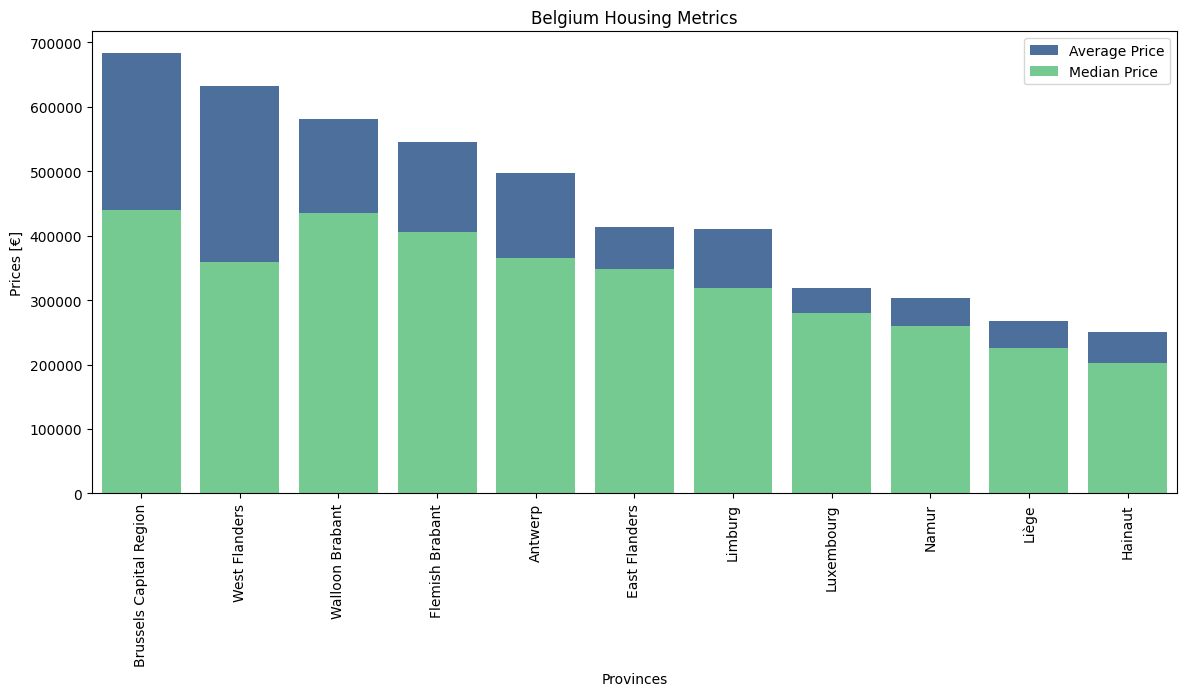

In [103]:
belgium_metrics = belgium_metrics.sort_values('Avg_Price',ascending=False)
plt.figure(figsize=(14, 6))
plt.xticks(rotation=90)
sns.barplot(data=belgium_metrics, x=belgium_metrics.index, y='Avg_Price', color='#3F6DA8', label='Average Price')
sns.barplot(data=belgium_metrics, x=belgium_metrics.index, y='Median_Price', color='#67D88E', label='Median Price')

plt.xlabel('Provinces')
plt.ylabel('Prices [€]')
plt.title('Belgium Housing Metrics')

plt.legend()
plt.show()

In [104]:
pd.set_option('display.float_format', '{:.2f}'.format)

print(f'Most expensive municipality in Belgium: {most_expensive_belgium}')
print(belgium_metrics.loc[most_expensive_belgium])
print(f'Least expensive municipality in Belgium: {least_expensive_belgium}')
print(belgium_metrics.loc[least_expensive_belgium])

print(f'Most expensive municipality in Flanders: {most_expensive_flanders}')
print(flanders_metrics.loc[most_expensive_flanders])
print(f'Least expensive municipality in Flanders: {least_expensive_flanders}')
print(flanders_metrics.loc[least_expensive_flanders])

print(f'Most expensive municipality in Wallonia: {most_expensive_wallonia}')
print(wallonia_metrics.loc[most_expensive_wallonia])
print(f'Least expensive municipality in Wallonia: {least_expensive_wallonia}')
print(wallonia_metrics.loc[least_expensive_wallonia])

print(f'Most expensive municipality in Brussels: {most_expensive_brussels}')
print(brussels_metrics.loc[most_expensive_brussels])
print(f'Least expensive municipality in Brussels: {least_expensive_brussels}')
print(brussels_metrics.loc[least_expensive_brussels])


Most expensive municipality in Belgium: Brussels Capital Region
Avg_Price            682773.87
Median_Price         440000.00
Price_Per_Sq_Meter     3884.83
Name: Brussels Capital Region, dtype: float64
Least expensive municipality in Belgium: Hainaut
Avg_Price            251081.68
Median_Price         202500.00
Price_Per_Sq_Meter     1622.17
Name: Hainaut, dtype: float64
Most expensive municipality in Flanders: West Flanders
Avg_Price            632345.78
Median_Price         359000.00
Price_Per_Sq_Meter     4875.91
Name: West Flanders, dtype: float64
Least expensive municipality in Flanders: Limburg
Avg_Price            410916.74
Median_Price         319000.00
Price_Per_Sq_Meter     2282.55
Name: Limburg, dtype: float64
Most expensive municipality in Wallonia: Walloon Brabant
Avg_Price            580771.98
Median_Price         435000.00
Price_Per_Sq_Meter     2909.52
Name: Walloon Brabant, dtype: float64
Least expensive municipality in Wallonia: Hainaut
Avg_Price            251081.68

In [105]:
summary_df = pd.DataFrame(np.nan, index=range(8), columns=['Region', 'Type', 'Province', 'Average Price'])

summary_df.loc[0] = ['Belgium', 'Most Expensive', most_expensive_belgium, belgium_metrics.loc[most_expensive_belgium, 'Avg_Price']]
summary_df.loc[1] = ['Belgium', 'Least Expensive', least_expensive_belgium, belgium_metrics.loc[least_expensive_belgium, 'Avg_Price']]

summary_df.loc[2] = ['Flanders', 'Most Expensive', most_expensive_flanders, flanders_metrics.loc[most_expensive_flanders, 'Avg_Price']]
summary_df.loc[3] = ['Flanders', 'Least Expensive', least_expensive_flanders, flanders_metrics.loc[least_expensive_flanders, 'Avg_Price']]

summary_df.loc[4] = ['Wallonia', 'Most Expensive', most_expensive_wallonia, wallonia_metrics.loc[most_expensive_wallonia, 'Avg_Price']]
summary_df.loc[5] = ['Wallonia', 'Least Expensive', least_expensive_wallonia, wallonia_metrics.loc[least_expensive_wallonia, 'Avg_Price']]

summary_df.loc[6] = ['Brussels', 'Most Expensive', most_expensive_brussels, brussels_metrics.loc[most_expensive_brussels, 'Avg_Price']]
summary_df.loc[7] = ['Brussels', 'Least Expensive', least_expensive_brussels, brussels_metrics.loc[least_expensive_brussels, 'Avg_Price']]

summary_df


,Region,Type,Province,Average Price
0,Belgium,Most Expensive,Brussels Capital Region,682773.87
1,Belgium,Least Expensive,Hainaut,251081.68
2,Flanders,Most Expensive,West Flanders,632345.78
3,Flanders,Least Expensive,Limburg,410916.74
4,Wallonia,Most Expensive,Walloon Brabant,580771.98
5,Wallonia,Least Expensive,Hainaut,251081.68
6,Brussels,Most Expensive,Brussels Capital Region,682773.87
7,Brussels,Least Expensive,Brussels Capital Region,682773.87


In [106]:
df_brussels = df[df['Province'] == 'Brussels Capital Region']
avg_prices_per_zip = df_brussels.groupby('Zip')['Price'].mean()
most_expensive_zip = avg_prices_per_zip.idxmax()
least_expensive_zip = avg_prices_per_zip.idxmin()

print(f'Most expensive ZIP code in Brussels: {most_expensive_zip} with an average price of {avg_prices_per_zip[most_expensive_zip]:.2f}')
print(f'Least expensive ZIP code in Brussels: {least_expensive_zip} with an average price of {avg_prices_per_zip[least_expensive_zip]:.2f}')

Most expensive ZIP code in Brussels: 1050 with an average price of 1203591.64
Least expensive ZIP code in Brussels: 1083 with an average price of 283877.60


In [117]:

avg_prices_per_zip = df.groupby('Zip')['Price'].mean()
most_expensive_zip = avg_prices_per_zip.idxmax()
least_expensive_zip = avg_prices_per_zip.idxmin()

print(f'Most expensive ZIP code in Belgium: {most_expensive_zip} with an average price of {avg_prices_per_zip[most_expensive_zip]:.2f}')
print(f'Least expensive ZIP code in Belgium: {least_expensive_zip} with an average price of {avg_prices_per_zip[least_expensive_zip]:.2f}')

Most expensive ZIP code in Belgium: 8902 with an average price of 2500000.00
Least expensive ZIP code in Belgium: 5680 with an average price of 49950.00


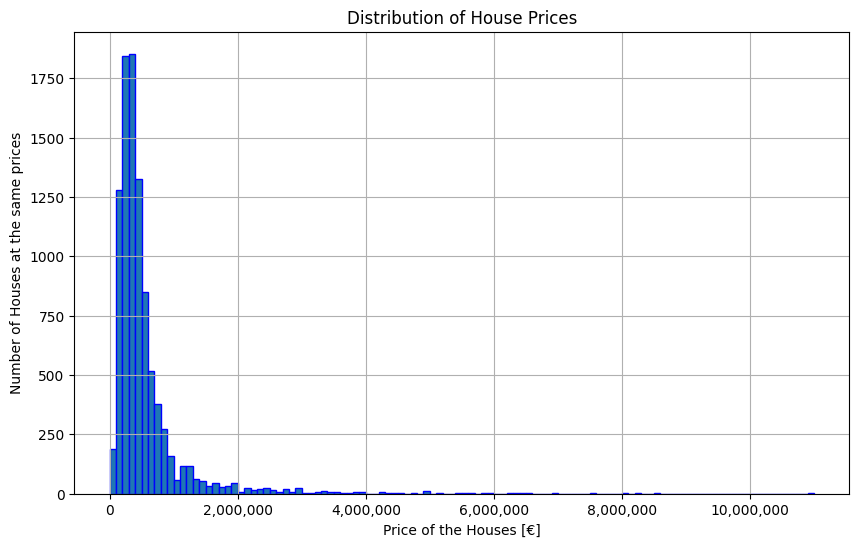

In [107]:
bins = range(0, df_houses['Price'].max() + 100000, 100000)

plt.figure(figsize=(10,6))
plt.hist(df_houses['Price'], bins=bins, edgecolor='blue')

plt.title('Distribution of House Prices')
plt.xlabel('Price of the Houses [€]')
plt.ylabel('Number of Houses at the same prices')
plt.grid(True)

ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.show()

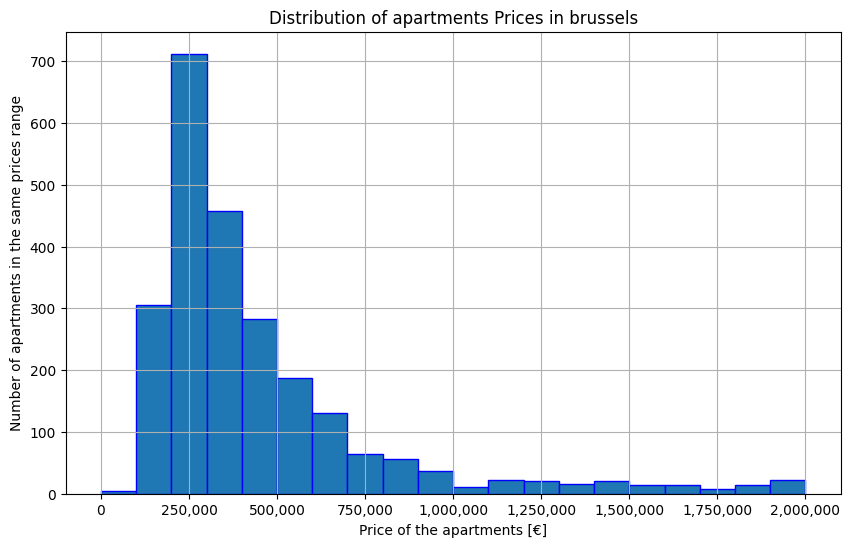

In [108]:
df_brussels_houses = df_brussels[df_brussels['Type of property'] == 'house']
df_brussels_apartments = df_brussels[df_brussels['Type of property'] == 'apartment']

df_brussels_apartments_filtered = df_brussels_apartments[df_brussels_apartments['Price'] < 2000000]

bins = range(0, df_brussels_apartments_filtered['Price'].max() + 100000, 100000)

plt.figure(figsize=(10,6))
plt.hist(df_brussels_apartments_filtered['Price'], bins=bins, edgecolor='blue')

plt.title('Distribution of apartments Prices in brussels')
plt.xlabel('Price of the apartments [€]')
plt.ylabel('Number of apartments in the same prices range')
plt.grid(True)

ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.show()

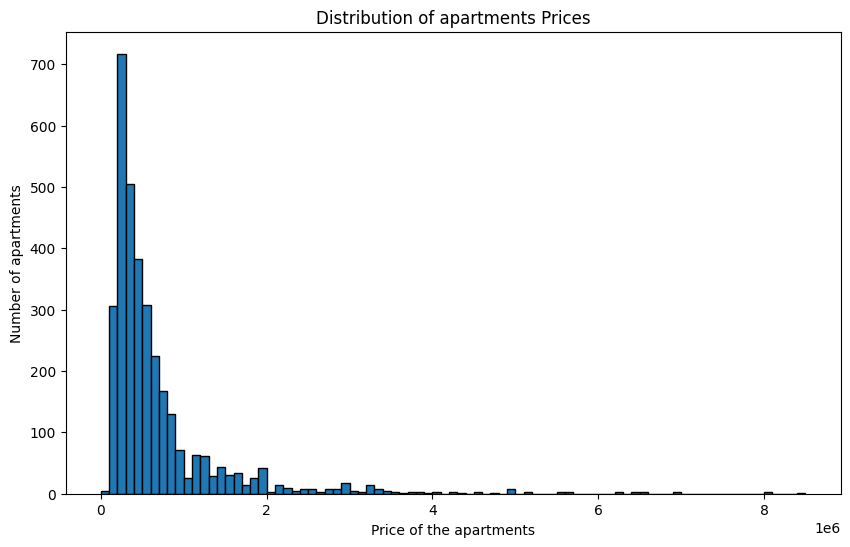

In [109]:
bins = range(0, df_brussels['Price'].max() + 100000, 100000)

plt.figure(figsize=(10,6))
plt.hist(df_brussels['Price'], bins=bins, edgecolor='black')
plt.title('Distribution of apartments Prices')
plt.xlabel('Price of the apartments')
plt.ylabel('Number of apartments')

plt.show()

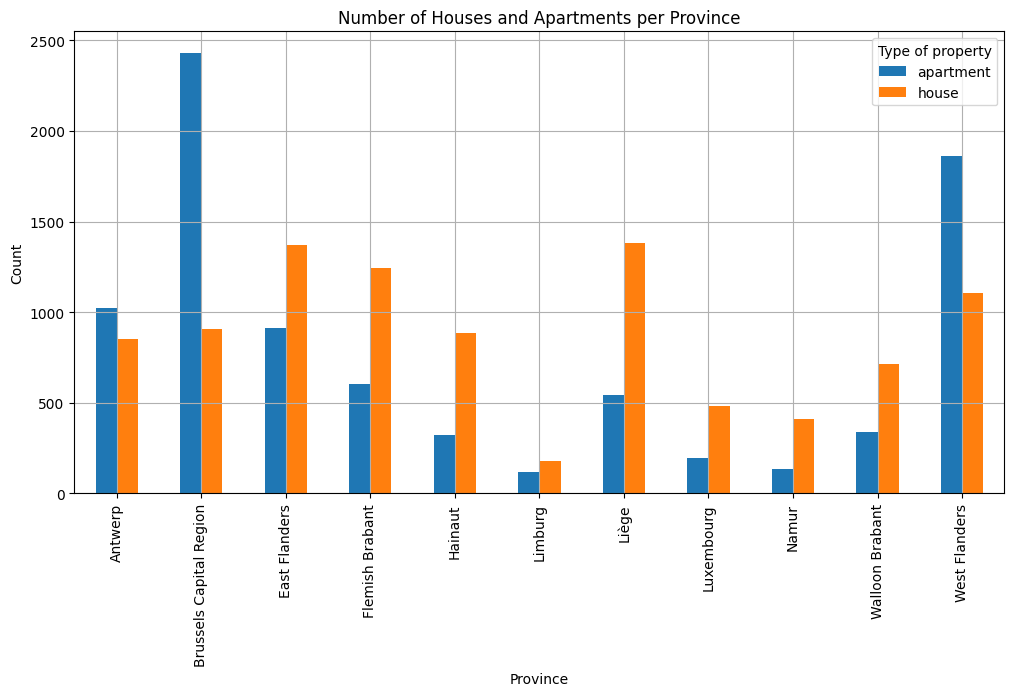

In [110]:
counts = df.groupby(['Province', 'Type of property']).size().unstack()

counts.plot(kind='bar', figsize=(12,6))

plt.title('Number of Houses and Apartments per Province')
plt.xlabel('Province')
plt.ylabel('Count')

plt.grid(True)
plt.show()

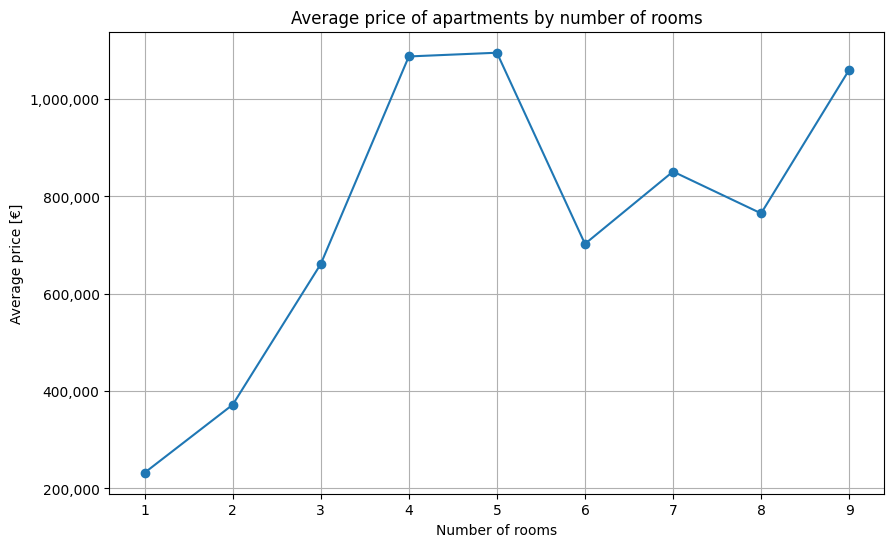

In [111]:
df_filtered = df_apartments[(df_apartments['Type of property'] == 'apartment') & (df_apartments['Number of rooms'] < 10)]
avg_price_per_rooms = df_filtered.groupby('Number of rooms')['Price'].mean()
avg_price_per_rooms.plot(kind='line', figsize=(10,6), marker='o')

plt.title('Average price of apartments by number of rooms')
plt.xlabel('Number of rooms')
plt.ylabel('Average price [€]')

plt.grid(True)

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.show()

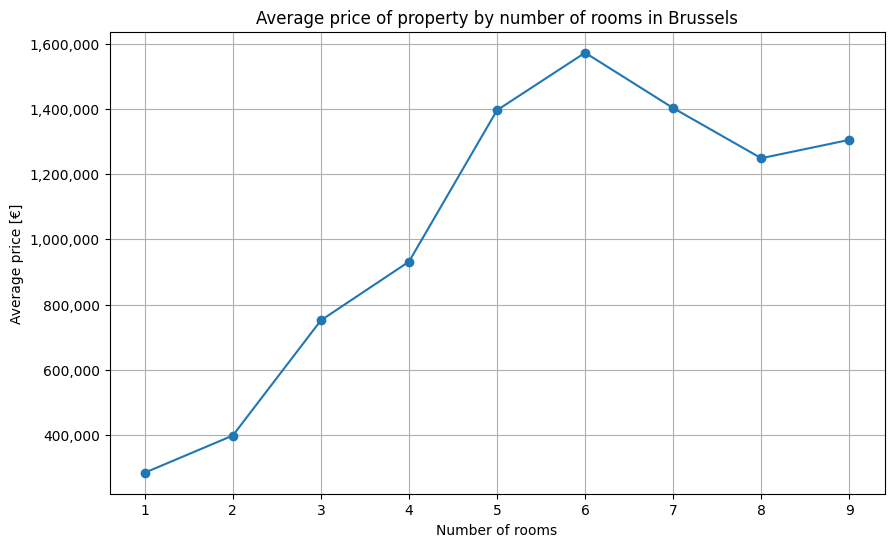

In [112]:
df_brussels_filtered = df_brussels[df_brussels['Number of rooms'] < 10]
avg_price_per_rooms = df_brussels_filtered.groupby('Number of rooms')['Price'].mean()
avg_price_per_rooms.plot(kind='line', figsize=(10,6), marker='o')

plt.title('Average price of property by number of rooms in Brussels')
plt.xlabel('Number of rooms')
plt.ylabel('Average price [€]')

plt.grid(True)

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.show()

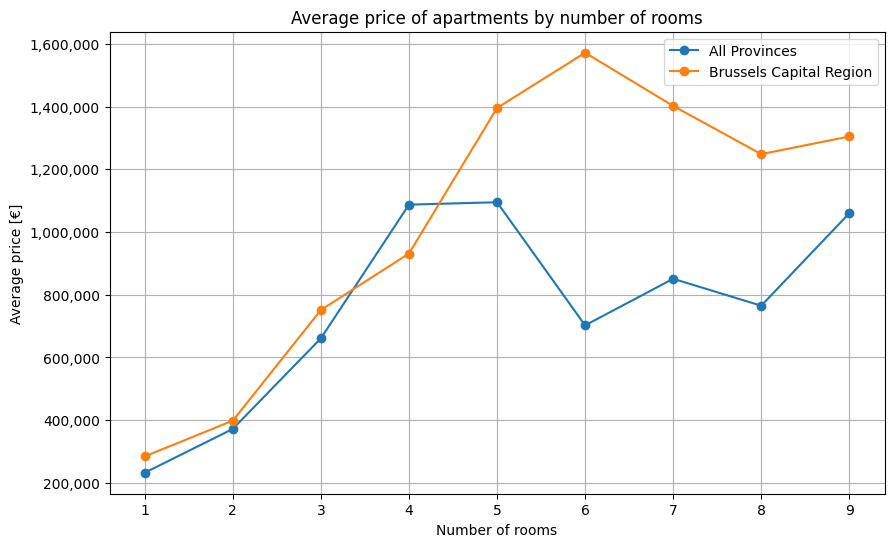

In [113]:
df_filtered = df_apartments[(df_apartments['Type of property'] == 'apartment') & (df_apartments['Number of rooms'] < 10)]
avg_price_per_rooms = df_filtered.groupby('Number of rooms')['Price'].mean()
df_brussels_filtered = df_brussels[df_brussels['Number of rooms'] < 10]
avg_price_per_rooms_brussels = df_brussels_filtered.groupby('Number of rooms')['Price'].mean()

plt.figure(figsize=(10,6))

avg_price_per_rooms.plot(kind='line', marker='o', label='All Provinces')
avg_price_per_rooms_brussels.plot(kind='line', marker='o', label='Brussels Capital Region')

plt.title('Average price of apartments by number of rooms')
plt.xlabel('Number of rooms')
plt.ylabel('Average price [€]')


plt.grid(True)


plt.legend()

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.show()

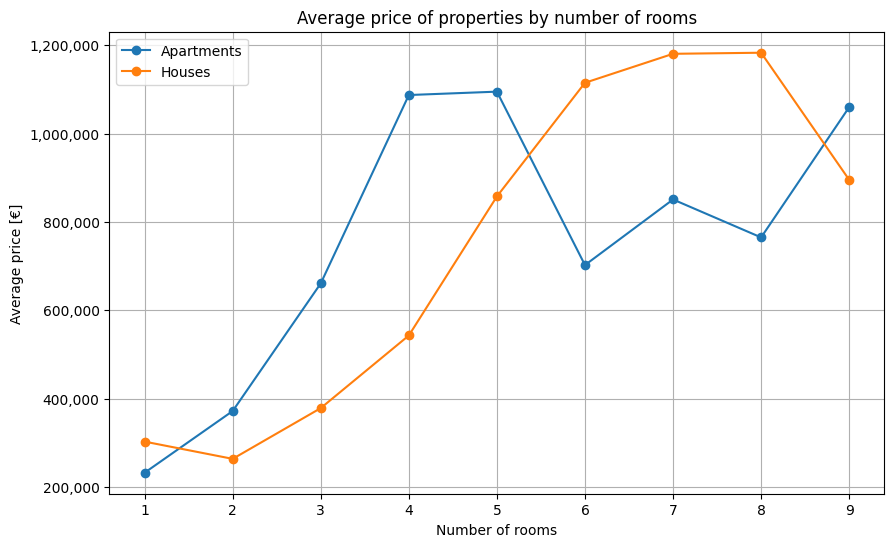

In [116]:
df_apartments_filtered = df_apartments[(df_apartments['Type of property'] == 'apartment') & (df_apartments['Number of rooms'] < 10)]
df_houses_filtered = df_houses[(df_houses['Type of property'] == 'house') & (df_houses['Number of rooms'] < 10)]

avg_price_per_rooms_apartments = df_apartments_filtered.groupby('Number of rooms')['Price'].mean()
avg_price_per_rooms_houses = df_houses_filtered.groupby('Number of rooms')['Price'].mean()

plt.figure(figsize=(10,6))

avg_price_per_rooms_apartments.plot(kind='line', marker='o', label='Apartments')
avg_price_per_rooms_houses.plot(kind='line', marker='o', label='Houses')

plt.title('Average price of properties by number of rooms')
plt.xlabel('Number of rooms')
plt.ylabel('Average price [€]')

plt.grid(True)
plt.legend()

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.show()

In [115]:
avg_prices = df.groupby('Locality')['Price'].mean()

zip_coordinates = {}
with open('BE.txt', 'r', encoding='utf-8') as file:
    for line in file:
        data = line.split('\t')
        zip_code = data[1]
        latitude = float(data[4])
        longitude = float(data[5])
        zip_coordinates[zip_code] = (latitude, longitude)
print(zip_coordinates)
heatmap_data = []
for zip_code, avg_price in avg_prices.items():
    if zip_code in zip_coordinates:
        latitude, longitude = zip_coordinates[zip_code]
        heatmap_data.append([latitude, longitude, avg_price])
m = Map(center=(50.5039, 4.4699), zoom=8)
heatmap_layer = Heatmap(locations=heatmap_data, radius=10, min_opacity=0.5, max_opacity=0.8)
m.add_layer(heatmap_layer)
m


{'Zuid-Willemsvaart': (50.86667, 5.65), 'Zoom': (50.83222, 4.35974), 'Wielingen': (51.41667, 3.41667), 'Vlakte van de Raan': (51.45, 3.23333), 'Putse Moer': (51.38333, 4.43333), 'Poppelsche Leij': (51.51667, 5.1), 'Moerbekepolder': (51.2, 3.93333), 'De Maatjes': (51.43333, 4.53333), 'Marksken': (51.41667, 4.9), 'Leijloop': (51.5, 4.78333), 'Kabeljauwbeek': (51.36667, 4.25), 'Itterbeek': (50.83803, 4.24948), 'Hollandsche Loop': (51.41667, 4.81667), 'Hazenduinen': (51.38333, 4.41667), 'Gulp': (50.81667, 5.9), 'Gueule': (50.9, 5.71667), 'Bedafsche Heide': (51.45, 5.01667), 'Ballastplaat': (51.36667, 4.23333), 'Appelzak': (51.38333, 3.38333), 'Weillen': (50.26081, 4.8266), 'Kanaal Brugge-Oostende': (51.23333, 2.93333), 'Canal Liége-Maastricht': (50.8, 5.7), 'Kanaal Gent-Brugge': (51.09341, 3.54827), 'Zwonderbeek': (51.11667, 4.43333), 'Zwinnevaart': (51.3, 3.3), 'Zwinebeek': (51.26667, 3.08333), 'Fort van Zwijndrecht': (51.20873, 4.30823), 'Zwijndrecht': (51.24001, 4.32674), 'Zwijnaardse D

Map(center=[50.5039, 4.4699], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…